In [56]:
%load_ext autoreload
%autoreload
from retro_branching.environments import EcoleBranching
from retro_branching.agents import StrongBranchingAgent, PseudocostBranchingAgent, RandomAgent
from retro_branching.utils import seed_stochastic_modules_globally, PlotAesthetics

import ecole

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate

import glob
from collections import defaultdict
import time
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set params

agent = RandomAgent()
# agent = PseudocostBranchingAgent()

co_class = 'set_covering'
co_class_kwargs = {'n_rows': 500, 'n_cols': 1000}

verbose = True

In [3]:
# load instances

instances_path = f'/scratch/datasets/retro_branching/instances/{co_class}'
for key,val in co_class_kwargs.items():
    instances_path += f'_{key}_{val}'
files = glob.glob(instances_path + '/*.mps')
print(f'Loaded {len(files)} instance files from {instances_path}\nFiles loaded:')
for file in files:
    print(file)

Loaded 100 instance files from /scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000
Files loaded:
/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/instance_92.mps
/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/instance_58.mps
/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/instance_66.mps
/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/instance_47.mps
/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/instance_73.mps
/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/instance_82.mps
/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/instance_75.mps
/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/instance_99.mps
/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/instance_22.mps
/scratch/da

In [4]:
%autoreload

seed = 0 # 1
seed_stochastic_modules_globally(default_seed=seed)

env = EcoleBranching(observation_function='default',
                      information_function='default',
                      reward_function='default',
                      scip_params='default')
env.seed(seed)

ecole.seed(seed)

stats_to_record = ['Episode Length', 'Episode Return']
plot_dict = {
             'Original': {stat: []  for stat in stats_to_record},
             'Retrospective': {stat: []  for stat in stats_to_record},
            }

In [5]:
%autoreload

subtree_reward_key = 'retro_binary_fathomed'
for i, file in enumerate(files):
    start = time.time()
    
    env.seed(seed)
    instance = ecole.scip.Model.from_file(file)
    agent.before_reset(instance)
    obs, action_set, reward, done, info = env.reset(instance)
    print(f'\nStarting episode {i+1} of {len(files)}...')
    
    step_counter = 0
    while not done:
        action, action_idx = agent.action_select(action_set, model=env.model, done=done)
        obs, action_set, reward, done, info = env.step(action)
        step_counter += 1
        
    print(f'Completed episode {i+1} in {time.time() - start:.3f} s.')
        
    # update whole tree stats
    plot_dict['Whole tree']['Episode Length'].append(step_counter)
    whole_tree_return = 0
    for sub_ep in reward[subtree_reward_key]:
        for r in sub_ep.values():
            whole_tree_return += r
    plot_dict['Whole tree']['Episode Return'].append(whole_tree_return)
    
    # update sub-tree stats
    for sub_ep in reward[subtree_reward_key]:
        plot_dict['Sub-trees']['Episode Length'].append(len(list(sub_ep.keys())))
        plot_dict['Sub-trees']['Episode Return'].append(sum(list(sub_ep.values())))
        
print(f'\nFinal plot_dict:\n{plot_dict}')


Starting episode 1 of 100...
Completed episode 1 in 0.380 s.

Starting episode 2 of 100...
Completed episode 2 in 25.552 s.

Starting episode 3 of 100...
Completed episode 3 in 4.670 s.

Starting episode 4 of 100...
Completed episode 4 in 1.043 s.

Starting episode 5 of 100...
Completed episode 5 in 3.769 s.

Starting episode 6 of 100...
Completed episode 6 in 0.319 s.

Starting episode 7 of 100...
Completed episode 7 in 21.411 s.

Starting episode 8 of 100...
Completed episode 8 in 2.225 s.

Starting episode 9 of 100...
Completed episode 9 in 4.166 s.

Starting episode 10 of 100...
Completed episode 10 in 1.187 s.

Starting episode 11 of 100...
Completed episode 11 in 6.648 s.

Starting episode 12 of 100...
Completed episode 12 in 1.092 s.

Starting episode 13 of 100...
Completed episode 13 in 18.518 s.

Starting episode 14 of 100...
Completed episode 14 in 43.005 s.

Starting episode 15 of 100...
Completed episode 15 in 4.117 s.

Starting episode 16 of 100...
Completed episode 16 in

In [11]:
# save plot dict
with open('subtree_vs_whole_tree_episode_length_plot_dict.pkl', 'wb') as f:
    pickle.dump(plot_dict, f)

In [82]:
# load plot dict
with open('subtree_vs_whole_tree_episode_length_plot_dict.pkl', 'rb') as f:
    plot_dict = pickle.load(f)

In [83]:
# rename keys if needed
if 'Whole tree' in plot_dict.keys():
    plot_dict['Retrospective'] = plot_dict.pop('Whole tree')
if 'Sub-trees' in plot_dict.keys():
    plot_dict['Original'] = plot_dict.pop('Sub-trees')

In [84]:
# Create dataframes (from above dict) for data manipulation and seaborn plotting (use display_name for legends)
_df = defaultdict(list)
for _agent in plot_dict.keys():
    for stat in plot_dict[_agent].keys():
        try:
            for el in plot_dict[_agent][stat]:
                _df[stat].append(el)
        except TypeError:
            # non-iterable, is already an element
            _df[stat].append(plot_dict[_agent][stat])
            
    for _ in range(len(plot_dict[_agent][stat])):
        _df['Agent'].append(_agent)
                        
for key, val in _df.items():
    print(key, len(val))
df = pd.DataFrame(_df)
if verbose:
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

Episode Length 24761
Episode Return 24761
Agent 24761
+------------------+------------------+---------------+
|   Episode Length |   Episode Return | Agent         |
|------------------+------------------+---------------|
|               23 |              -19 | Retrospective |
|             3826 |            -3060 | Retrospective |
|              735 |             -568 | Retrospective |
|              106 |              -82 | Retrospective |
|              499 |             -417 | Retrospective |
|               20 |              -17 | Retrospective |
|             3156 |            -2508 | Retrospective |
|              311 |             -251 | Retrospective |
|              558 |             -436 | Retrospective |
|              130 |             -106 | Retrospective |
|              947 |             -770 | Retrospective |
|              114 |              -95 | Retrospective |
|             2682 |            -2131 | Retrospective |
|             6139 |            -4954 | Retrospect

In [85]:
# # config
# context = 'paper'
# style = 'whitegrid'
# font_scale = 2
# palette = 'hls'
# fig_size = (4, 2)
# linewidth = 2.5

# sns.set_theme(font_scale=font_scale,
#               context=context,
#               style=style,
#               palette=palette)


# plot_legend = False

# ylog = True
# xlog = True

In [86]:
# config
ylabel = 'Proportion'

plot_legend = True

ylog = True
xlog = True

scaling_factor = 0.6
width_scaling_factor = 1.5
height_scaling_factor = 1

aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics()

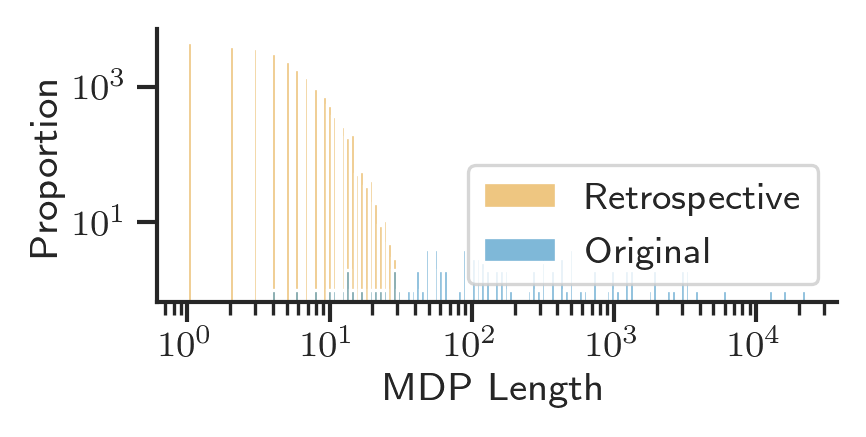

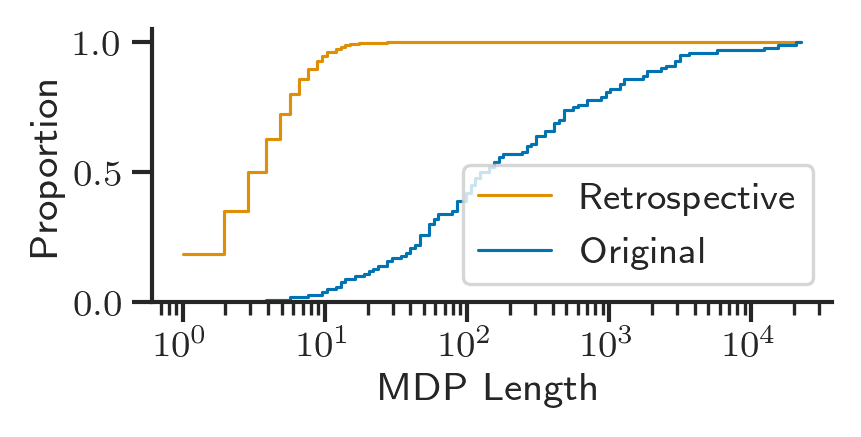

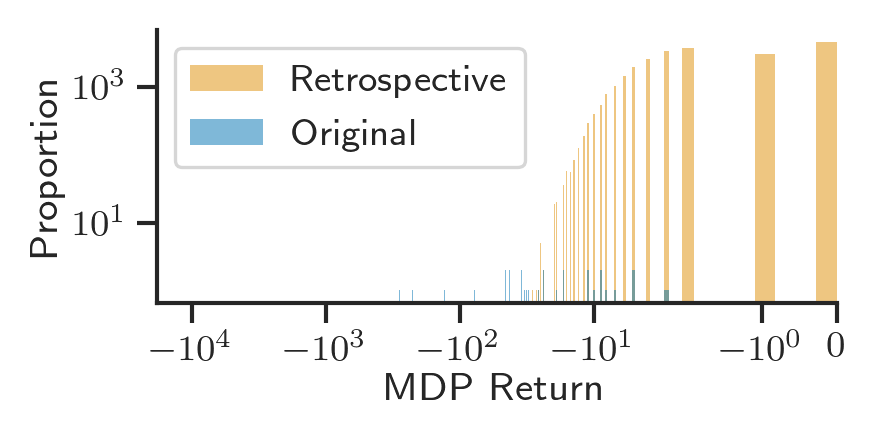

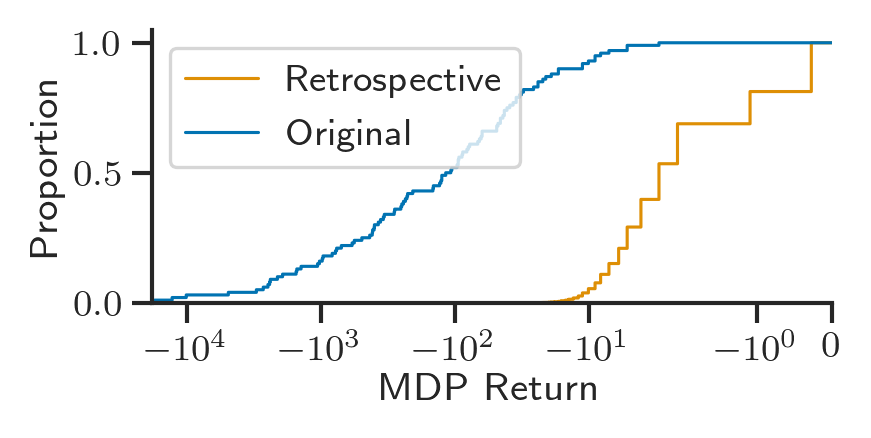

In [87]:
# sns.set_theme(font_scale=font_scale,
#               context=context,
#               style=style,
#               palette=palette)


# EPISODE LENGTH
f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.histplot(data=df, x='Episode Length', hue='Agent', log_scale=xlog, legend=plot_legend)
plt.xlabel('MDP Length')
plt.ylabel(ylabel)
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
if ylog:
    g.set(yscale='log')
if plot_legend:
    plt.legend(title=None, labels=list(plot_dict.keys()), loc='lower right')
plt.gcf().patch.set_alpha(0.0)
plt.show()

f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.histplot(data=df, x='Episode Length', hue='Agent', log_scale=xlog, cumulative=True, stat='density', fill=False, common_norm=False, element='step', legend=plot_legend, linewidth=aesthetics.linewidth)
plt.xlabel('MDP Length')
plt.ylabel(ylabel)
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
if plot_legend:
    plt.legend(title=None, labels=list(plot_dict.keys()))
plt.gcf().patch.set_alpha(0.0)
plt.show()


# EPISODE RETURN
f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.histplot(data=df, x='Episode Return', hue='Agent', legend=plot_legend)
plt.xlabel('MDP Return')
plt.ylabel(ylabel)
if ylog:
    g.set(yscale='log')
plt.xscale('symlog')
plt.xlim(right=0)
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
if plot_legend:
    plt.legend(title=None, labels=list(plot_dict.keys()))
plt.gcf().patch.set_alpha(0.0)
plt.show()

f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.histplot(data=df, x='Episode Return', hue='Agent', cumulative=True, stat='density', fill=False, common_norm=False, element='step', legend=plot_legend, linewidth=aesthetics.linewidth)
plt.xlabel('MDP Return')
plt.ylabel(ylabel)
plt.xscale('symlog')
plt.xlim(right=0)
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
if plot_legend:
    plt.legend(title=None, labels=list(plot_dict.keys()), loc='upper left')
plt.gcf().patch.set_alpha(0.0)
plt.show()

In [ ]:
for agent in plot_dict.keys():
    for stat in plot_dict[agent].keys():
        print(f'{agent} -> mean {stat}: {np.mean(plot_dict[agent][stat])} | std {stat}: {np.std(plot_dict[agent][stat])}')